In [1]:
%matplotlib inline

import sys
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('data/prescriptions2017_clean.csv.gz', compression='gzip')

In [2]:
medications = outliers.getOverdoseMedications(prescription)
medications.shape

(73,)

In [3]:
all_times  = []

for med in np.asarray(medications):

    methods_time = pd.DataFrame()
    
    X, Y = outliers.getPrescriptions(prescription, med)
    anomalies = len(Y[Y==1])
    total = len(X)
    
    if len(X) < 30000:
        continue

    print(med + ', Size: ', total, ' Overdose: ', anomalies)
        
    index_list = np.append([], [])
    skf = StratifiedKFold(n_splits=anomalies)
    div = 1
    for train_index, test_index in skf.split(X, Y):
            
            
        index_list = np.append(index_list.astype(int), test_index.astype(int))
        size = len(index_list)
            
        X_train = X[index_list]
        Y_train = Y[index_list]
        overdose_size = len(Y_train[Y_train==1])
        
        if (size // 3000) < div:
            continue
            
        size_idx = div * 3000
        div = 1 + (size // 3000)
        
        sys.stdout.write(str(overdose_size) + '/' + str(size) +', ')
            
        epsilon = 0.5
        p_svm = [epsilon,4]
        p_cov = [epsilon]
        p_ift = [epsilon]
        p_lof = [500,epsilon]
        p_wpr = [epsilon]
        p_gmx = [epsilon]
        results = outliers.evaluateMethods(X_train, Y_train, p_svm, p_cov, p_ift, p_lof, p_wpr, p_gmx, debug=False)

        for idx in results.index:
            methods_time.loc[idx, size_idx] = results.loc[idx,'Time']

        if size > 30000:
            break

    all_times.append(methods_time)
        #break
    
    if len(all_times) > 5:
        break
            
print('Done')

DIPIRONA 1 g/2 ml SOL INJ, Size:  163027  Overdose:  618
12/3168, 23/6072, 35/9240, 46/12144, 57/15048, 69/18216, 80/21120, 91/24024, 103/27192, 114/30096, LACTULOSE 667 mg/ml SOL ORAL, Size:  33395  Overdose:  90
9/3344, 17/6312, 25/9280, 33/12248, 41/15216, 49/18184, 57/21152, 65/24120, 73/27088, 81/30056, PARACETAMOL 500 mg CP, Size:  82749  Overdose:  116
5/3570, 9/6426, 13/9282, 17/12138, 22/15708, 26/18564, 30/21420, 34/24276, 38/27132, 43/30700, Done


In [10]:
all_times[1]

,3000,6000,9000,12000,15000,18000,21000,24000,27000,30000
LOF,0.399,0.839,1.372,1.740,2.423,3.007,3.644,4.112,4.693,5.004
DDC-J,0.043,0.047,0.052,0.060,0.066,0.070,0.072,0.080,0.083,0.088
Cov,0.470,0.513,0.594,0.718,0.819,0.960,1.170,1.273,1.372,1.653
Gau,0.008,0.016,0.016,0.022,0.026,0.034,0.035,0.039,0.045,0.053
DDC-H,0.050,0.062,0.070,0.085,0.091,0.099,0.104,0.116,0.121,0.129
IsoF,0.308,0.497,0.681,0.863,1.047,1.222,1.451,1.625,1.772,1.991
SVM,0.263,0.919,1.987,3.544,5.563,8.131,11.102,14.595,18.591,23.249
DDC-M,0.057,0.072,0.084,0.101,0.110,0.116,0.118,0.139,0.144,0.155
DDC-C,0.070,0.088,0.104,0.132,0.143,0.194,0.163,0.197,0.204,0.220


In [15]:
mean_time = pd.DataFrame(np.zeros((9,10)), index=results.index, columns=np.arange(3000,30001,3000))

for df in all_times:
    for m in df.index:
        for s in df.columns:
            mean_time.loc[m,s] += df.loc[m,s]

mean_time = ( mean_time.values / len(all_times) )
mean_time = pd.DataFrame(mean_time, index=results.index, columns=np.arange(3000,30001,3000))
mean_time

,3000,6000,9000,12000,15000,18000,21000,24000,27000,30000
LOF,0.437000,0.887333,1.485667,1.969333,2.748667,3.533000,4.256667,5.006667,5.897000,6.675667
DDC-J,0.027667,0.029333,0.033333,0.037667,0.041667,0.044000,0.046333,0.049667,0.052333,0.054667
Cov,0.339333,0.404333,0.469000,0.552333,0.638000,0.736000,0.880000,0.984000,1.089667,1.255000
Gau,0.006667,0.011000,0.013667,0.016000,0.019000,0.026000,0.026333,0.029000,0.032667,0.036667
DDC-H,0.029000,0.035333,0.041333,0.047333,0.051333,0.055000,0.058667,0.063667,0.066667,0.070333
IsoF,0.244667,0.386667,0.527333,0.652000,0.810333,0.943333,1.112333,1.265667,1.383333,1.543333
SVM,0.192667,0.669667,1.458000,2.516000,4.000333,5.774000,7.815000,10.210333,12.958667,16.268667
DDC-M,0.031667,0.039000,0.046000,0.053000,0.057667,0.061000,0.063667,0.071333,0.074333,0.079000
DDC-C,0.036667,0.045333,0.053667,0.064667,0.070667,0.089333,0.081000,0.093000,0.096667,0.102667


In [13]:
mean_time = mean_time.reindex_axis(sorted(methods_time.columns), axis=1)

def smooth(x,beta):
    """ kaiser window smoothing """
    window_len=11
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[5:len(y)-5]

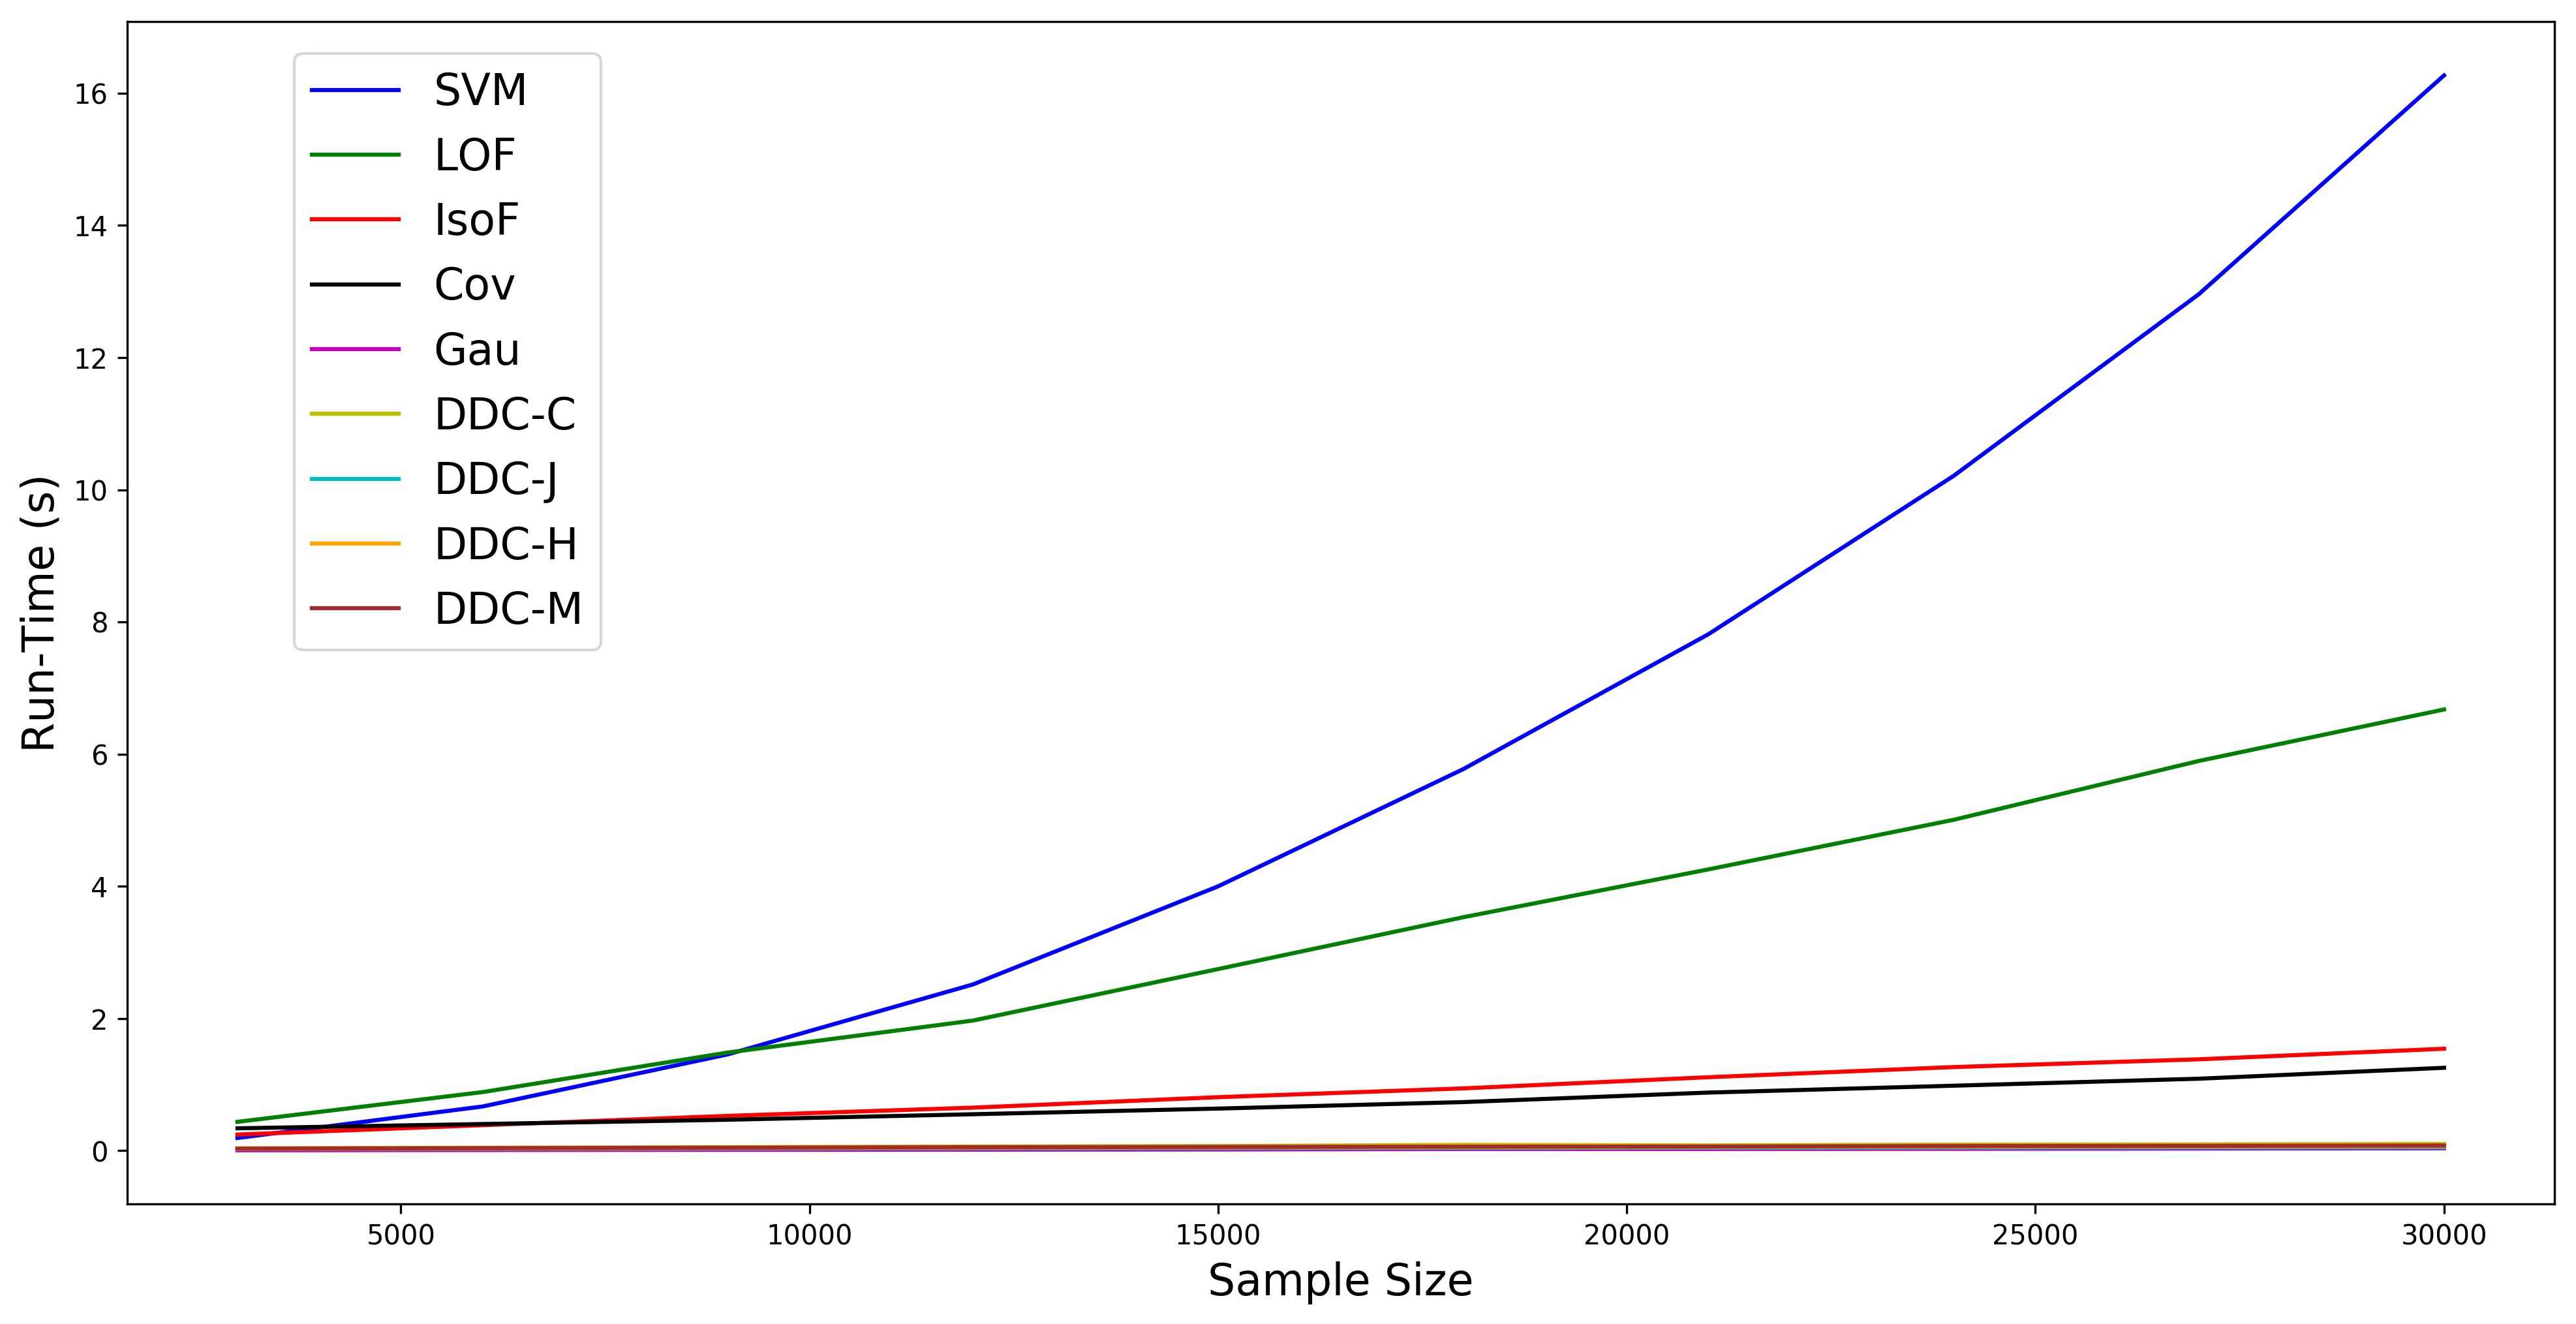

In [26]:
plt.figure(figsize=(16, 8), dpi= 300)
methods = ['SVM','LOF','IsoF','Cov','Gau','DDC-C','DDC-J','DDC-H','DDC-M']
colors = ['b', 'g', 'r', 'k', 'm', 'y', 'c', 'orange', 'brown']
i = 0
for m in methods:
    plt.plot(np.asarray(mean_time.columns),np.asarray(mean_time.loc[m].values), c=colors[i],label=m)
    i += 1
    
plt.legend(bbox_to_anchor=(0.06, 0.45), fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Run-Time (s)', fontsize=16)
#plt.ylim(0,22)
#plt.xlim(0,28000)
plt.show()